<a href="https://githubtocolab.com/alsinmr/ConferenceExamples/blob/master/GNMR2023/BMRD.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg"></a>

# Bloch-McConnell Relaxation Dispersion
In this notebook, we investigate how BMRD can be used to separate the two-state populations from the change in chemical shift, where separating $p_1p_2$ from $\Delta\omega_{12}^2$ requires off-resonance irradiation

In [ ]:
!git clone https://github.com/alsinmr/ConferenceExamples.git
%cd /content/ConferenceExamples/GNMR2023
import setup

In [ ]:
#Sometimes, there is a delay between setup finishing and being able to complete the module loads
from importlib.machinery import SourceFileLoader #Why do I need to use this instead of a simple import?
RS = SourceFileLoader("pyRelaxSim", "/content/pyRelaxSim/__init__.py").load_module()  
import numpy as np
import matplotlib.pyplot as plt
from time import time

In [1]:
import sys
sys.path.append('/Users/albertsmith/Documents/GitHub')
sys.path.append('/Users/albertsmith/Documents/GitHub.nosync')
import SLEEPY as RS
import numpy as np
import matplotlib.pyplot as plt
from time import time

The relevant formulas are as follows:
\begin{equation}
R_{1\rho}^{ex}=\frac{\sin^2\beta_ep_1p_2\Delta\omega_{12}^2k_{ex}}{\frac{\omega_{e1}\omega_{e2}^2}{\omega_e^2}+k_{ex}^2-\sin^2\beta_ep_1p_2\Delta\omega_{12}^2\left(1+\frac{2k_{ex}^2(p_1\omega_{e1}^2+p_2\omega_{e2}^2)}{\omega_{e1}^2\omega_{e2}^2+\omega_e^2k_{ex}^2}\right)}
\end{equation}
with the following definitions:
\begin{eqnarray}
\Omega&=&p_1\Omega_1+p_2\Omega_2 \\
\Delta\omega_{12}&=&\Omega_1-\Omega_2 \\
\omega_e^2&=&\omega_1^2+\Omega^2 \\
\omega_{e1}^2&=&\omega_1^2+\Omega_1^2 \\
\omega_{e2}^2&=&\omega_1^2+\Omega_2^2 \\
\sin^2\beta_e&=&\frac{\omega_1^2}{\omega_1^2+\Omega^2}
\end{eqnarray}

## Define parameters, define the spin-system

In [2]:
p1=0.75  #Population 1
p2=1-p1  #Population 2
tc=3e-4     #Correlation time
DelOmega12=500  #Change in Chemical Shift

ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)

## Build the Liouvillian, add the exchange process

In [3]:
L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian

print(f'The mean chemical shift is {ex0.inter[0]["ppm"]*p1+ex1.inter[0]["ppm"]*p2:.2f} ppm')

The mean chemical shift is 0.00 ppm


## Create a propagator with on-resonant spin-lock, calculate $R_{1\rho}$ relaxation

<AxesSubplot:xlabel='$t$ / ms', ylabel='<$^{13}C_x$>'>

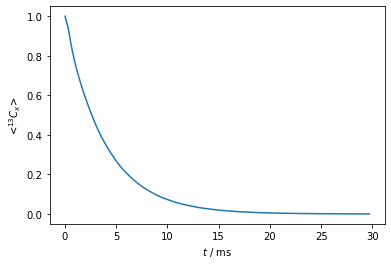

In [4]:
seq=L.Sequence()
seq.add_channel('13C',v1=500)  #Spin lock at -3.5 ppm (on-resonance)
U=seq.U(.0003)  #Propagator (10 ms)

rho=RS.Rho(rho0='13Cx',detect='13Cx')
rho.DetProp(U,n=100)

rho.plot(axis='ms')

### What happens if we vary the populations and $\Delta\omega_{12}^2$, but leave $p_1p_2\Delta\Omega^2$ fixed?

*Slow exchange*

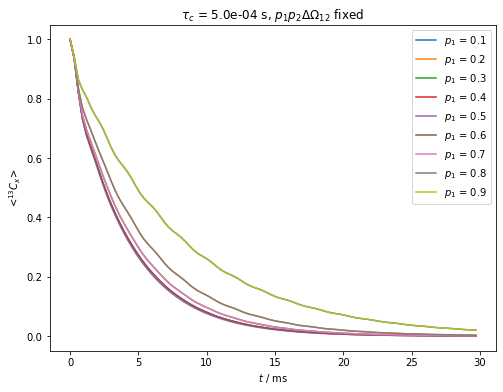

In [5]:
ax=plt.subplots()[1]
tc=5e-4
p1p2DelOmega2=46875
p10=np.linspace(0.1,.9,9)
for p1 in p10:
    p2=1-p1
    DelOmega12=np.sqrt(p1p2DelOmega2/p1/p2)
    ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
    ex1=ex0.copy()
    ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
    ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)
    L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
    L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
    seq=L.Sequence()
    seq.add_channel('13C',v1=500)  #Spin lock at -3.5 ppm (on-resonance)
    U=seq.U(.0003)  #Propagator (10 ms)
    rho=RS.Rho(rho0='13Cx',detect='13Cx')
    rho.DetProp(U,n=100)
    rho.plot(axis='ms',ax=ax)
ax.legend([r'$p_1$ = '+f'{p1:.1f}' for p1 in p10])
ax.figure.set_size_inches([8,6])
_=ax.set_title(r'$\tau_c$ = '+f'{tc:.1e} s'+r', '+'$p_1p_2\Delta\Omega_{12}$ fixed')

*Fast exchange*

Text(0.5, 1.0, '$\\tau_c$ = 1.0e-05 s, $p_1p_2\\Delta\\Omega_{12}$ fixed')

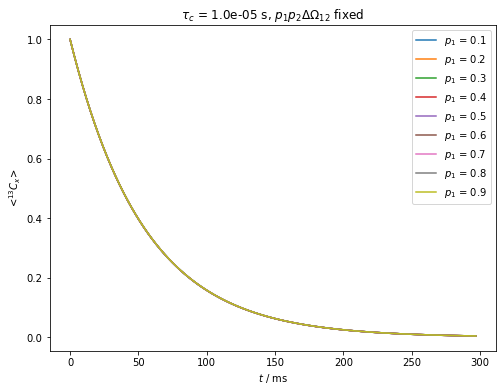

In [6]:
ax=plt.subplots()[1]
tc=1e-5
p10=np.linspace(0.1,.9,9)
p1p2DelOmega2=46875

for p1 in p10:
    p2=1-p1
    DelOmega12=np.sqrt(p1p2DelOmega2/p1/p2)
    ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
    ex1=ex0.copy()
    ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
    ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)
    L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
    L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
    seq=L.Sequence()
    seq.add_channel('13C',v1=500)  #Spin lock at -3.5 ppm (on-resonance)
    U=seq.U(.003)  #Propagator (10 ms)
    rho=RS.Rho(rho0='13Cx',detect='13Cx')
    rho.DetProp(U,n=100)
    rho.plot(axis='ms',ax=ax)
ax.legend([r'$p_1$ = '+f'{p1:.1f}' for p1 in p10])
ax.figure.set_size_inches([8,6])
ax.set_title(r'$\tau_c$ = '+f'{tc:.1e} s'+r', '+'$p_1p_2\Delta\Omega_{12}$ fixed')

In the case of fast exchange, only the product, $p_1p_2\Delta\Omega_{12}^2$ influences the relaxation, so that we cannot separate populations from the change in chemical shift.

Next, we test for slow exchange, what happens if the field strength is set too high

Text(0.5, 1.0, '$\\tau_c$ = 5.0e-04 s, $p_1p_2\\Delta\\Omega_{12}$ fixed')

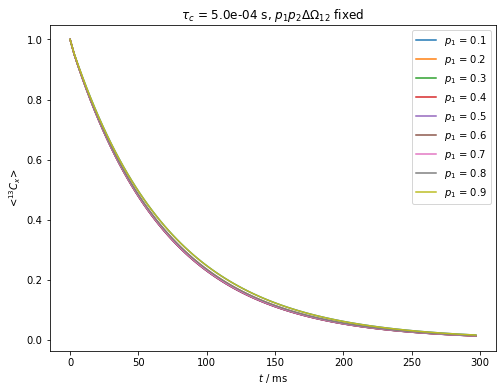

In [46]:
ax=plt.subplots()[1]
tc=5e-4
p10=np.linspace(0.1,.9,9)
p1p2DelOmega2=46875

for p1 in p10:
    p2=1-p1
    DelOmega12=np.sqrt(p1p2DelOmega2/p1/p2)
    ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
    ex1=ex0.copy()
    ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
    ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)
    L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
    L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
    seq=L.Sequence()
    seq.add_channel('13C',v1=2500)  #Spin lock at -3.5 ppm (on-resonance)
    U=seq.U(.003)  #Propagator (10 ms)
    rho=RS.Rho(rho0='13Cx',detect='13Cx')
    rho.DetProp(U,n=100)
    rho.plot(axis='ms',ax=ax)
ax.legend([r'$p_1$ = '+f'{p1:.1f}' for p1 in p10])
ax.figure.set_size_inches([8,6])
ax.set_title(r'$\tau_c$ = '+f'{tc:.1e} s'+r', '+'$p_1p_2\Delta\Omega_{12}$ fixed')

The stronger field slows down the relaxation considerably, but furthermore, no longer can we separate $p_1p_2$ from $\Delta\Omega_{12}$. This becomes critical in solid-state NMR, where we need to be able to apply low fields while retain a spin-lock. This can become problematic due to other large, anisotropic interactions, such that we need to spin quickly and decrease the $^1$H concentration to avoid higher order effects.

Next, we determine the behavior of relaxation as a function of offset frequency. First, we calculate a spectrum to see where peaks actually appear (and also mark where peaks should be in the absence of exchange).

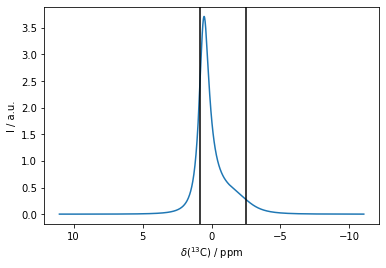

In [42]:
ax=plt.subplots()[1]
tc=5e-4
p1=0.75
p2=1-p1
p1p2DelOmega2=46875
DelOmega12=np.sqrt(p1p2DelOmega2/p1/p2)

ex0=RS.ExpSys(v0H=600,Nucs='13C',T_K=298) #We need a description of the experiment for both states (ex0, ex1)
ex1=ex0.copy()
ex0.set_inter(Type='CS',i=0,ppm=DelOmega12/ex0.v0[0]*1e6*p2)
ex1.set_inter(Type='CS',i=0,ppm=-DelOmega12/ex0.v0[0]*1e6*p1)

L=RS.Liouvillian((ex0,ex1))  #Builds the two different Hamiltonians and exports them to Liouville space
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
U=L.U(.0003)  #Propagator (10 ms)
rho0=RS.Rho(rho0='13Cx',detect='13Cp')
rho0.DetProp(U,n=1000)
rho0.plot(axis='ppm',ax=ax,FT=True)
ax.set_ylim(ax.get_ylim())
ax.plot(ex0.inter[0]['ppm']*np.ones(2),ax.get_ylim(),color='black')
ax.plot(ex1.inter[0]['ppm']*np.ones(2),ax.get_ylim(),color='black')

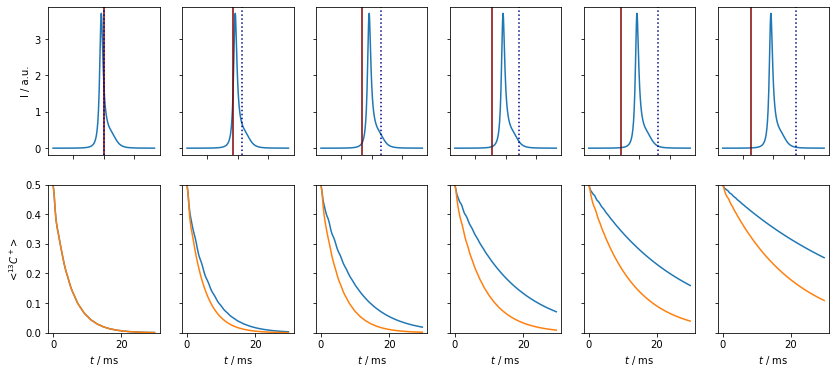

In [36]:
voff0=np.linspace(0,750,6)
tc=5e-4
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian
U=L.U(.0003)  #Propagator (10 ms)
rho0=RS.Rho(rho0='13Cx',detect='13Cp')
rho0.DetProp(U,n=1000)

fig,ax=plt.subplots(2,len(voff0))
fig.set_size_inches([14,6])
rho=RS.Rho(rho0='13Cz',detect='13Cp')
Dt=.0003
for voff,a in zip(voff0,ax.T):
    a[1].set_ylim([0,.5])
    rho0.plot(FT=True,ax=a[0],axis='Hz',color='black')
    yl=a[0].get_ylim()
    a[0].plot(voff*np.ones(2),yl,color='maroon')
    a[0].plot(-voff*np.ones(2),yl,color='darkblue',linestyle=':')
    a[0].set_ylim(yl)
    
    flip=np.arcsin(500/np.sqrt(500**2+voff**2))
    Uflip0=L.Sequence().add_channel('13C',v1=100000,t=[0,flip/100000/2/np.pi],phase=np.pi/2).U()
    Uflip1=L.Sequence().add_channel('13C',v1=100000,t=[0,(np.pi/2-flip)/100000/2/np.pi+1e-10],phase=np.pi/2).U()
    rho.clear()
    
                   
    seq=L.Sequence().add_channel('13C',v1=-500,voff=voff)
    U=seq.U(Dt)
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='maroon')
    
    seq=L.Sequence().add_channel('13C',v1=500,voff=-voff)
    U=seq.U(Dt)
    
    rho.clear()
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='darkblue',linestyle=':')
    
    if not(a[0].is_first_col()):
        a[0].set_ylabel('')
        a[0].set_yticklabels('')
        a[1].set_ylabel('')
        a[1].set_yticklabels('')
    a[0].set_xlabel('')
    a[0].set_xticklabels('')
        

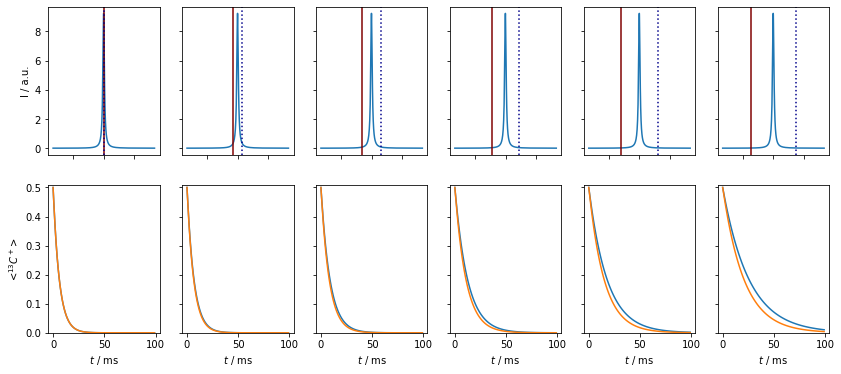

In [39]:
tc=1e-4
L.kex=RS.Tools.twoSite_kex(tc=tc,p1=p1) #Add exchange to the Liouvillian

U=L.U(.0003)  #Propagator (.3 ms)
rho0=RS.Rho(rho0='13Cx',detect='13Cp')
rho0.DetProp(U,n=1000)

voff0=np.linspace(0,750,6)
fig,ax=plt.subplots(2,len(voff0))
fig.set_size_inches([14,6])
rho=RS.Rho(rho0='13Cz',detect='13Cp')
Dt=.001
for voff,a in zip(voff0,ax.T):
    a[1].set_ylim([0,.51])
    rho0.plot(FT=True,ax=a[0],axis='Hz',color='black')
    yl=a[0].get_ylim()
    a[0].plot(voff*np.ones(2),yl,color='maroon')
    a[0].plot(-voff*np.ones(2),yl,color='darkblue',linestyle=':')
    a[0].set_ylim(yl)
    flip=np.arcsin(500/np.sqrt(500**2+voff**2))
    Uflip0=L.Sequence().add_channel('13C',v1=100000,t=[0,flip/100000/2/np.pi],phase=np.pi/2).U()
    Uflip1=L.Sequence().add_channel('13C',v1=100000,t=[0,(np.pi/2-flip)/100000/2/np.pi+1e-10],phase=np.pi/2).U()
    rho.clear()
    
                   
    seq=L.Sequence().add_channel('13C',v1=-500,voff=voff)
    U=seq.U(Dt)
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='maroon')
    
    seq=L.Sequence().add_channel('13C',v1=500,voff=-voff)
    U=seq.U(Dt)
    
    rho.clear()
    for n in range(100):
        rho.reset()
        (Uflip1*(U**n)*Uflip0*rho)()
    rho.plot(axis='ms',ax=a[1],color='darkblue',linestyle=':')
    
    if not(a[0].is_first_col()):
        a[0].set_ylabel('')
        a[0].set_yticklabels('')
        a[1].set_ylabel('')
        a[1].set_yticklabels('')
    a[0].set_xlabel('')
    a[0].set_xticklabels('')
        